### OpenVaccine - Stanford University - XGBoost
The following notebook constructs an XGBoost regression model to predict the degradation rate of mRNA molecules in the OpenVaccine competition held by Stanford University. 

#### 0. Import Libraries

In [1]:
!pip3 install -q forgi[all]
!conda install -y -c bioconda viennarna

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - viennarna


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    viennarna-2.5.0            |   py37hfecc14a_0        16.8 MB  bioconda
    ------------------------------------------------------------
                                           Total:        16.8 MB

The following NEW packages will be INSTALLED:

  viennarna          bioconda/linux-64::viennarna-2.5.0-py37hfecc14a_0



viennarna-2.5.0      | 16.8 MB   | ##################################### | 100% 
Preparing 

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import forgi.graph.bulge_graph as fgb
import forgi.visual.mplotlib as fvm
sns.set(style='darkgrid')

#### 1. Exploratory Data Analysis

In [3]:
# load data
train = pd.read_json('../input/stanford-covid-vaccine/train.json',lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json', lines=True)
sample_sub = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')

##### 1.1 Shape of Input and Output and Important Variables Explained

In [4]:
# examine the shape of input and output
print("train data shape: ", train.shape)
print("test data shape: ", test.shape)
print("sample submission shape: ", sample_sub.shape)

train data shape:  (2400, 19)
test data shape:  (3634, 7)
sample submission shape:  (457953, 6)


- 2400 training examples, each with 19 attributes
- 3634 testing examples, each with 7 attributes (629 public samples + 3005 private samples)
- Public test data has Sequence length of 107, while private test data has Sequence length of 130 (explanation after). Prediction is required for every position on the sequence for every sample. Hence, total rows in submission = 629 * 107 + 3005 * 130 = 457,953

In [5]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


**Important variables**
- seq_length - Int, the length of sequence.
- sequence - An array of A, G, U, and C. Describes the RNA sequence. **Main feature**
- structure - An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired.
- reactivity, deg_pH10, deg_Mg_pH10, deg_50C,deg_Mg_50C - An array of floating point numbers. Five indexes of the likelihood of degradation under different conditions. **Ground-truth Values**
- SN_filter - Int, 1 if it satisfies the below given conditions or else 0. The filter will also be applied to the public test set and private test set.
    - Minimum value across all 5 conditions must be greater than -0.5.
    - Mean signal/noise across all 5 conditions must be greater than 1.0.

In [6]:
test.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


Five targeted variables as well as several variables (SN_filter, signal_to_noise, errors) are removed. These removed variables can't be used as features in the later model.

In [7]:
sample_sub.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


For every position of every example (denoted by id_seqpos), all five indexes are predicted.

In [8]:
train['seq_length'].value_counts()

107    2400
Name: seq_length, dtype: int64

All the examples in the training data are of 107 sequence length.

In [9]:
test['seq_length'].value_counts()

130    3005
107     629
Name: seq_length, dtype: int64

- 629 examples in the test set are of 107 sequence length, the same as the training set, and they form the public test set.
- 3005 examples in the test set are of 130 sequence length, which together form the private test set.
- The variation in the sequence length between the public test set and the private test set is aimed to examine the generalization ability of the model.

##### 1.2 Distribution of Signal/Noise and SN_filter

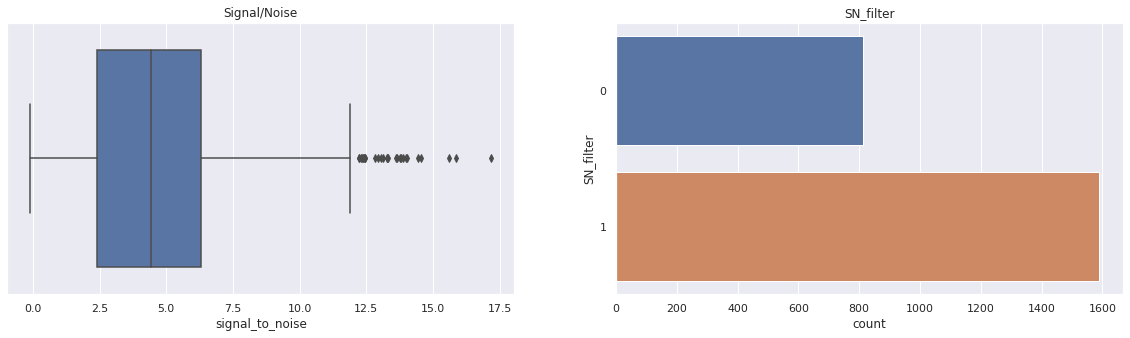

In [10]:
# plot the boxplot of Signal/Noise and the barplot of SN_filter
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(data=train, x='signal_to_noise', ax=ax[0])
ax[0].set_title('Signal/Noise')
sns.countplot(data=train, y='SN_filter', ax=ax[1])
ax[1].set_title('SN_filter')
plt.show()

- There are samples with very high Signal/Noise values, which could be outliers.
- About 2/3 of the training samples have SN_filter of 1, which denotes that the example is relatively "good". **Removing samples with SN_filter of 0 in the training process might be a good choice.**

##### 1.3 Distribution of Ground-Truth vs Position

In [11]:
# Reference: https://www.kaggle.com/meemr5/openvaccine-interesting-visualizations
# obtain the average values of five indexes over positions
avg_reactivity = np.array(list(map(np.array,train.reactivity))).mean(axis=0)
avg_deg_50C = np.array(list(map(np.array,train.deg_50C))).mean(axis=0)
avg_deg_pH10 = np.array(list(map(np.array,train.deg_pH10))).mean(axis=0)
avg_deg_Mg_50C = np.array(list(map(np.array,train.deg_Mg_50C))).mean(axis=0)
avg_deg_Mg_pH10 = np.array(list(map(np.array,train.deg_Mg_pH10))).mean(axis=0)

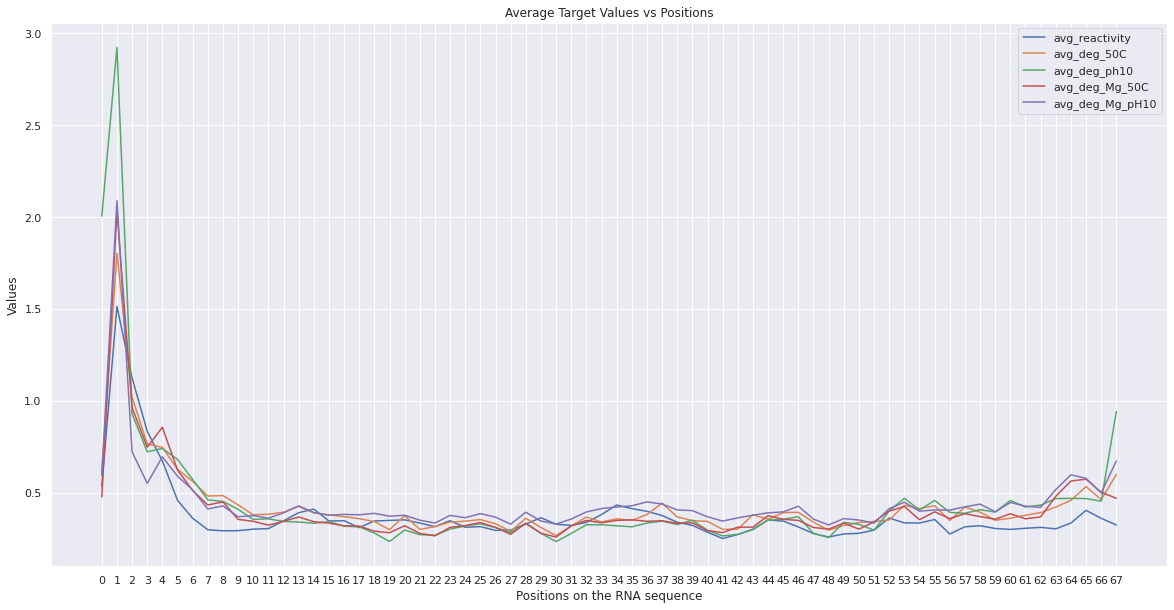

In [12]:
# plot of the average values of five indexes over positions vs positions
plt.figure(figsize=(20,10))

sns.lineplot(x=range(68),y=avg_reactivity,label='avg_reactivity')
sns.lineplot(x=range(68),y=avg_deg_50C,label='avg_deg_50C')
sns.lineplot(x=range(68),y=avg_deg_pH10,label='avg_deg_ph10')
sns.lineplot(x=range(68),y=avg_deg_Mg_50C,label='avg_deg_Mg_50C')
sns.lineplot(x=range(68),y=avg_deg_Mg_pH10,label='avg_deg_Mg_pH10')

plt.xlabel('Positions on the RNA sequence')
plt.xticks(range(0,68))
plt.ylabel('Values')
plt.title('Average Target Values vs Positions')

plt.show()

- There is a certain pattern regarding the distribution of Reactivity and degradation: they tend to be high at the beginning of the sequence and stable and low in the middle.
- There is some correlation between these five indexes.


In [13]:
# correlation between the five indexes
np.corrcoef(np.vstack((avg_reactivity, avg_deg_50C, avg_deg_pH10, avg_deg_Mg_50C, avg_deg_Mg_pH10)))

array([[1.        , 0.93444797, 0.79443553, 0.92013372, 0.85894052],
       [0.93444797, 1.        , 0.88413015, 0.98090941, 0.94806805],
       [0.79443553, 0.88413015, 1.        , 0.85404104, 0.89446958],
       [0.92013372, 0.98090941, 0.85404104, 1.        , 0.96517128],
       [0.85894052, 0.94806805, 0.89446958, 0.96517128, 1.        ]])

Almost all correlation coefficients exceed 0.8, indicating indeed high correlation between indexes.

##### 1.4 RNA Visualization

To better understand the sequence and structure of RNA, we use a tool named viennarna to construct RNA models and visualize them from RNA structures and sequences.

In [14]:
# plotting function
def plot_sample(sample):
    
    """
    Reference: https://www.kaggle.com/erelin6613/openvaccine-rna-visualization
    Visualize RNA using viennarna
    Arguments:
    sample: pandas.series, a sample of RNA, must contain 'id', structure' and 'sequence'
    
    """
    struct = sample['structure']
    seq = sample['sequence']
    bg = fgb.BulgeGraph.from_fasta_text(f'>rna1\n{struct}\n{seq}')[0]
    
    plt.figure(figsize=(20,8))
    fvm.plot_rna(bg)
    plt.title(f"RNA Structure (id: {sample.id})")
    plt.show()

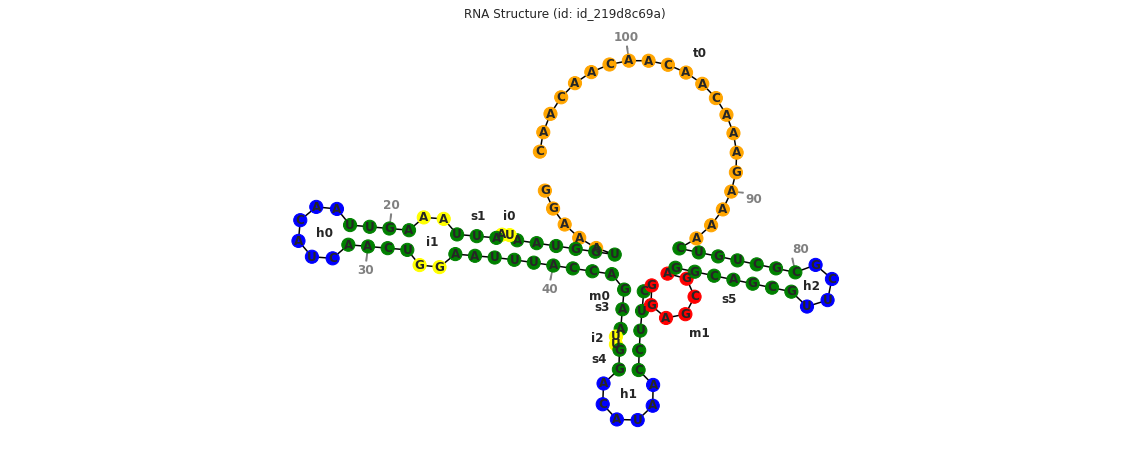

In [15]:
# example
sample = train.iloc[np.random.choice(2400)]
plot_sample(sample)

#### 2. Predition with XGBoost Regression

##### 2.1 Preprocess

As we have stated in 1.2, we remove training samples with SN_filter of 0.

In [16]:
# filter training data with SN_filter
mask = train['SN_filter'] == 1
train = train[mask]

And we drop useless columns for now.

In [17]:
# remove explanatory variables not available in the test set
train = train.drop(['signal_to_noise', 'SN_filter', 'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C'], axis = 1)
train.shape

(1589, 12)

Since prediction is required for all positions of every sample, we break every sample down into pieces.

In [18]:
# rearrange training data so that one row represents one position of one sample
train_data = []

for ID in train['id'].unique():
    entry = train.loc[train['id'] == ID]     
    for i in range(entry['seq_scored'].values[0]):
        sample_dict = {'id': entry['id'].values[0],
                       'id_seqpos': str(entry['id'].values[0]) + '_' + str(i),
                       'sequence': entry['sequence'].values[0][i],
                       'structure': entry['structure'].values[0][i],
                       'predicted_loop_type': entry['predicted_loop_type'].values[0][i],
                       'reactivity': entry['reactivity'].values[0][i],
                       'deg_Mg_pH10': entry['deg_Mg_pH10'].values[0][i],
                       'deg_pH10': entry['deg_pH10'].values[0][i],
                       'deg_Mg_50C': entry['deg_Mg_50C'].values[0][i],
                       'deg_50C': entry['deg_50C'].values[0][i]}
        train_data.append(sample_dict)
        
train_data = pd.DataFrame(train_data)
train_data.head()

,id,id_seqpos,sequence,structure,predicted_loop_type,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,id_001f94081_0,G,.,E,0.3297,0.7556,2.3375,0.3581,0.6382
1,id_001f94081,id_001f94081_1,G,.,E,1.5693,2.9830,3.5060,2.9683,3.4773
2,id_001f94081,id_001f94081_2,A,.,E,1.1227,0.2526,0.3008,0.2589,0.9988
3,id_001f94081,id_001f94081_3,A,.,E,0.8686,1.3789,1.0108,1.4552,1.3228
4,id_001f94081,id_001f94081_4,A,.,E,0.7217,0.6376,0.2635,0.7244,0.7877


In [19]:
# same for the test data
test_data = []

for ID in test['id'].unique():
    entry = test.loc[test['id'] == ID]     
    for i in range(entry['seq_length'].values[0]):
        sample_dict = {'id': entry['id'].values[0],
                       'id_seqpos': str(entry['id'].values[0]) + '_' + str(i),
                       'sequence': entry['sequence'].values[0][i],
                       'structure': entry['structure'].values[0][i],
                       'predicted_loop_type': entry['predicted_loop_type'].values[0][i]}
        test_data.append(sample_dict)
        
test_data = pd.DataFrame(test_data)
test_data.head()

,id,id_seqpos,sequence,structure,predicted_loop_type
0,id_00073f8be,id_00073f8be_0,G,.,E
1,id_00073f8be,id_00073f8be_1,G,.,E
2,id_00073f8be,id_00073f8be_2,A,.,E
3,id_00073f8be,id_00073f8be_3,A,.,E
4,id_00073f8be,id_00073f8be_4,A,.,E


'squence', 'structure' and 'predicted_loop_type' are all floats. We turn them into integers using dictionaries.

In [20]:
# convert string to float
dict_sequence = {'A': 0, 'G' : 1, 'U' : 2, 'C' : 3}
dict_structure = {'(' : 0, ')' : 1, '.' : 2}
dict_looptype = {'S':0, 'M':1, 'I':2, 'B':3, 'H':4, 'E':5, 'X':6}

train_data['sequence'] = train_data['sequence'].replace(dict_sequence)
train_data['structure'] = train_data['structure'].replace(dict_structure)
train_data['predicted_loop_type'] = train_data['predicted_loop_type'].replace(dict_looptype)

test_data['sequence'] = test_data['sequence'].replace(dict_sequence)
test_data['structure'] = test_data['structure'].replace(dict_structure)
test_data['predicted_loop_type'] = test_data['predicted_loop_type'].replace(dict_looptype)

train_data.head()

,id,id_seqpos,sequence,structure,predicted_loop_type,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,id_001f94081_0,1,2,5,0.3297,0.7556,2.3375,0.3581,0.6382
1,id_001f94081,id_001f94081_1,1,2,5,1.5693,2.9830,3.5060,2.9683,3.4773
2,id_001f94081,id_001f94081_2,0,2,5,1.1227,0.2526,0.3008,0.2589,0.9988
3,id_001f94081,id_001f94081_3,0,2,5,0.8686,1.3789,1.0108,1.4552,1.3228
4,id_001f94081,id_001f94081_4,0,2,5,0.7217,0.6376,0.2635,0.7244,0.7877


In [21]:
# split data in features and labels
X_train = train_data.drop(['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C'], axis=1)
Y_train = train_data[['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]

In [22]:
# split training set and test set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((86441, 5), (21611, 5), (86441, 5), (21611, 5))

##### 2.2 Define Loss Function

In [23]:
# loss function used for scoring
def mcrmse_loss(y_true, y_pred, N = 5):
    """
    Calculates competition eval metric
    """
    n = len(y_true)
    return np.sum(np.sqrt(np.sum((y_true - y_pred)**2, axis = 0)/n)) / N

##### 2.3 Construct Model

In [24]:
# XGBoost Regressor model, best parameters after testing
xgb = XGBRegressor(
    n_estimators=800,
    eval_metric='rmse',
    learning_rate=0.1,
    subsample=0.8, # prevent overfitting
    colsample_bytree=0.8 # prevent overfitting
)

In [25]:
# delete from X features not used for prediction ('id', 'id_seqpos')
features = ['sequence', 'structure', 'predicted_loop_type']
targets = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
sub = pd.DataFrame(test_data['id_seqpos'])
feature_importances = pd.DataFrame(index=features)
# train X
tr_X = X_train[features]
# validation X
vl_X = X_val[features]
# test X
ts_X = test_data[features]
tr_X.shape, vl_X.shape, ts_X.shape

((86441, 3), (21611, 3), (457953, 3))

In [26]:
# train and test
for i in range(5):
    tr_Y, vl_Y = Y_train[targets[i]], Y_val[targets[i]]
    # train
    xgb.fit(tr_X, tr_Y)
    feature_importances.insert(i, targets[i], xgb.feature_importances_)
    # validate
    vl_pred = xgb.predict(vl_X)
    loss = mcrmse_loss(vl_Y, vl_pred)
    print(f'{targets[i]} loss : {loss}')
    # test
    sub[targets[i]] = xgb.predict(ts_X)

reactivity loss : 0.0764024782149597
deg_Mg_pH10 loss : 0.09584439400165636
deg_pH10 loss : 0.08832974042589657
deg_Mg_50C loss : 0.0870414383808795
deg_50C loss : 0.07380866385952459


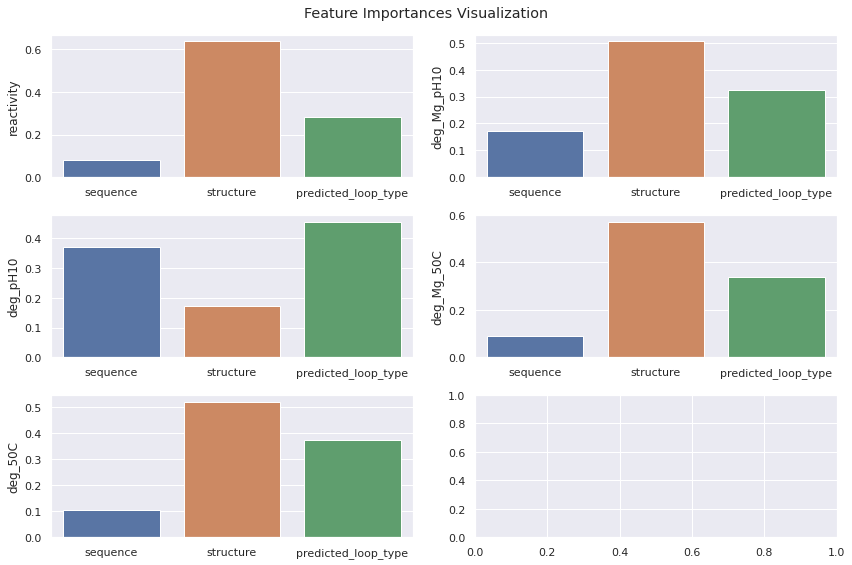

In [27]:
# feature importances visualization
fig, ax = plt.subplots(3, 2, figsize = (12, 8))
fig.suptitle('Feature Importances Visualization')
for i in range(5):
    sns.barplot(x = features, y = targets[i], data=feature_importances, ax=ax[i // 2][i % 2])
plt.tight_layout()
plt.show()

In [28]:
# submission file
sub.to_csv('submission.csv', index=False)
sub.shape, sub.head()

((457953, 6),
         id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
 0  id_00073f8be_0    0.907978     1.172703  1.962681    1.115597  1.111055
 1  id_00073f8be_1    0.907978     1.172703  1.962681    1.115597  1.111055
 2  id_00073f8be_2    0.651081     0.538713  0.615610    0.681124  0.686707
 3  id_00073f8be_3    0.651081     0.538713  0.615610    0.681124  0.686707
 4  id_00073f8be_4    0.651081     0.538713  0.615610    0.681124  0.686707)

##### 2.4 Visualize Results

Finally, we pick up several samples randomly and visualize our prediction results.

In [29]:
# prediction results visualization
sub['id'], sub['seqpos'] = sub['id_seqpos'].str.rsplit('_', 1).str
sub['seqpos'] = sub['seqpos'].astype(int)
sub = sub.sort_values(by=['id', 'seqpos']).reset_index(drop=True)
# sampling
reac0 = sub.groupby('id')['reactivity'].apply(list)[0]
reac1 = sub.groupby('id')['reactivity'].apply(list)[1000]
reac2 = sub.groupby('id')['reactivity'].apply(list)[2000]
reac3 = sub.groupby('id')['reactivity'].apply(list)[3000]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


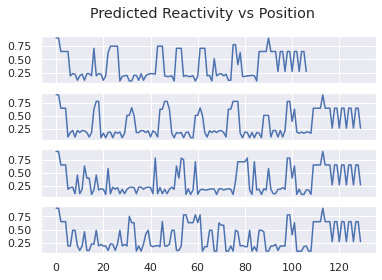

In [30]:
# predicted reactivity vs position plot
fig, ax = plt.subplots(4, 1, sharex=True)
fig.suptitle('Predicted Reactivity vs Position')
sns.lineplot(data = reac0, ax=ax[0])
sns.lineplot(data = reac1, ax=ax[1])
sns.lineplot(data = reac2, ax=ax[2])
sns.lineplot(data = reac3, ax=ax[3])
plt.show()